## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [2]:
from keras import regularizers

In [3]:
import os

In [4]:
mylist= os.listdir('RawData/')

In [5]:
type(mylist)

list

In [6]:
print(mylist[1439])

03-02-01-01-01-01-01.wav


In [7]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [8]:
data, sampling_rate = librosa.load('RawData/03-01-01-01-01-01-17.wav')

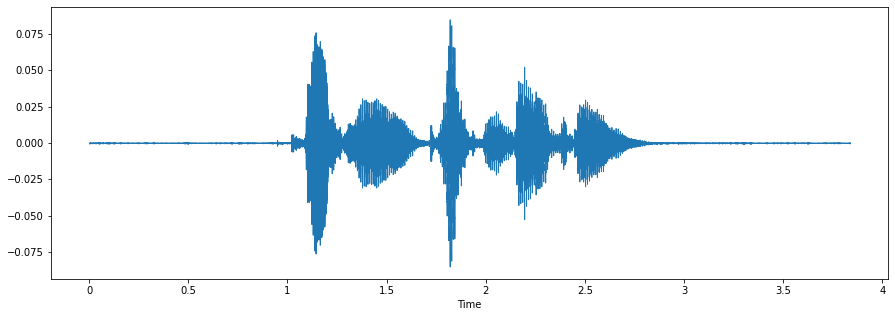

In [9]:
# % pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

<ipython-input-10-91112b59f701>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('RawData/03-01-01-01-01-01-17.wav')


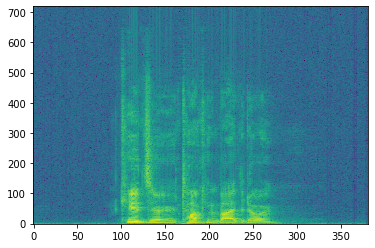

In [10]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/03-01-01-01-01-01-17.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [11]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [12]:
labels = pd.DataFrame(feeling_list)

In [13]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [14]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [15]:
df[:5]

,feature
0,"[-70.26808, -70.26808, -70.26808, -70.26808, -..."
1,"[-65.707375, -65.707375, -63.11476, -61.5191, ..."
2,"[-65.48282, -65.48282, -65.48282, -65.48282, -..."
3,"[-64.52863, -64.52863, -64.52863, -64.52863, -..."
4,"[-63.64624, -59.99512, -61.87015, -67.49628, -..."


In [16]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [17]:
newdf = pd.concat([df3,labels], axis=1)

In [18]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [19]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.242519,-61.356304,male_calm
1,-65.707375,-65.707375,-63.114761,-61.519100,-61.097507,-63.424744,-63.720127,-56.854958,-55.169304,-54.640343,...,-39.792603,-40.614010,-41.209984,-41.439613,-43.994671,-49.399967,-50.591972,-49.112217,-48.155739,female_calm
2,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,...,-31.348972,-34.310616,-35.803104,-35.938644,-37.633038,-40.119911,-41.663399,-41.552986,-41.974155,male_calm
3,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-65.928391,...,-48.674789,-48.596626,-47.603226,-43.049660,-42.660038,-43.189026,-44.001690,-43.328537,-42.985413,female_calm
4,-63.646240,-59.995121,-61.870152,-67.496277,-71.072220,-65.680321,-63.394951,-65.503853,-61.858971,-60.007893,...,-39.072914,-41.896793,-40.866917,-38.293266,-36.375122,-37.914906,-40.027390,-43.315861,-44.848812,male_calm


In [20]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
62,-54.740135,-55.849667,-57.078987,-56.740311,-56.328194,-54.951927,-56.146683,-57.529514,-57.926270,-55.627022,...,-39.522579,-41.310505,-43.606461,-45.284012,-45.988155,-47.077557,-45.722908,-46.303017,-43.644249,male_calm
622,-54.671219,-54.671219,-54.671219,-54.671219,-54.671219,-54.671219,-54.671219,-54.671219,-54.671219,-54.671219,...,-54.335667,-53.139107,-53.503616,-54.579765,-53.146133,-51.377384,-52.044579,-52.768894,-53.230911,male_angry
29,-72.010048,-72.010048,-72.010048,-72.010048,-72.010048,-72.010048,-72.010048,-72.010048,-72.010048,-72.010048,...,-44.934868,-45.039616,-45.178726,-45.872707,-46.678879,-45.873295,-47.405453,-39.508915,-34.060524,female_calm
334,-50.106785,-50.106785,-50.106785,-50.106785,-50.106785,-50.106785,-50.106785,-50.106785,-50.106785,-50.106785,...,-50.106785,-50.106785,-50.106785,-50.106785,-50.106785,-50.106785,-50.106785,-50.106785,-50.106785,male_happy
103,-55.026772,-55.061794,-56.980759,-60.773769,-55.672104,-53.730881,-53.669838,-53.159058,-54.004616,-55.970520,...,-52.857201,-49.181229,-49.217812,-50.819218,-50.600113,-50.947685,-50.488197,-51.935787,-53.666767,female_calm
794,-54.872124,-54.471821,-54.633587,-55.004646,-54.126160,-53.985344,-54.347843,-54.995316,-56.836205,-56.798885,...,-21.382336,-21.050617,-22.935282,-25.554024,-27.868874,-29.028688,-29.760176,-30.858217,-34.074471,male_fearful
752,-40.591553,-41.074425,-40.987331,-41.231609,-42.389503,-43.125145,-43.653130,-44.034428,-43.265640,-42.934036,...,-14.644001,-14.742428,-15.980686,-15.483383,-16.631718,-17.281694,-18.545702,-19.273409,-21.880117,male_angry
22,-61.802761,-60.646858,-62.531990,-65.584671,-65.793739,-65.793739,-65.793739,-65.793739,-65.793739,-63.589458,...,-27.551537,-27.641397,-28.516582,-29.206562,-30.010088,-30.120575,-33.494560,-36.219173,-39.304867,male_calm
856,-45.664753,-45.317463,-43.909969,-43.639217,-44.616512,-43.998344,-43.589237,-44.078598,-43.901077,-42.735996,...,-40.460670,-40.520531,-40.442223,-41.478508,-42.777687,-41.823704,-41.062725,-40.098568,-35.736046,male_fearful
877,-45.646233,-45.646233,-45.646233,-45.646233,-45.646233,-45.646233,-45.646233,-45.646233,-45.646233,-45.646233,...,-45.646233,-45.646233,-45.646233,-45.646233,-45.646233,-45.646233,-45.646233,-45.646233,-45.646233,female_fearful


In [21]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [22]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [23]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
209,-61.509174,-61.509174,-61.509174,-61.509174,-61.509174,-61.509174,-61.509174,-61.509174,-61.509174,-61.509174,...,-58.432762,-59.560993,-61.320339,-61.258080,-61.497559,-61.509174,-61.509174,-61.509174,-61.509174,female_happy
366,-46.064941,-46.386196,-47.110897,-47.066711,-46.836342,-46.537247,-47.593819,-47.908745,-48.006371,-47.703392,...,-17.752300,-16.027477,-14.915831,-14.831944,-15.079024,-17.684635,-18.024517,-17.831869,-18.417200,male_happy
159,-64.821457,-64.821457,-64.821457,-64.821457,-64.821457,-64.821457,-64.821457,-64.821457,-64.821457,-64.821457,...,-44.219501,-43.710510,-46.265560,-47.687843,-47.515766,-51.758305,-55.012295,-55.067421,-56.318672,female_calm
235,-63.175663,-63.175663,-63.175663,-63.175663,-63.175663,-63.175663,-63.175663,-63.175663,-63.175663,-63.175663,...,-53.112991,-54.409084,-53.847763,-56.180481,-56.905964,-55.876308,-58.143120,-59.260494,-60.303379,female_happy
870,-50.970013,-51.055588,-51.295700,-51.205482,-51.139606,-51.077267,-50.993549,-50.938862,-51.016087,-51.336910,...,-40.807373,-41.791809,-42.938454,-43.265160,-45.303703,-46.191036,-48.113995,-46.533428,-47.495193,male_fearful
417,-54.692505,-51.036320,-49.884480,-48.928318,-49.139809,-53.262386,-53.435810,-51.280334,-50.158302,-51.227539,...,-52.368675,-53.364239,-51.723568,-50.929626,-52.154095,-51.638977,-50.850502,-52.870220,-52.253738,female_sad
522,-57.199951,-56.649551,-58.384972,-61.521988,-64.582008,-64.264771,-63.681999,-61.965805,-63.487923,-64.641068,...,-51.865257,-52.474205,-51.909306,-54.379883,-53.660519,-53.956566,-52.872200,-51.809177,-53.106915,male_sad
821,-63.375122,-61.009460,-60.393532,-60.479393,-61.317410,-64.020103,-60.963615,-60.685184,-62.826859,-62.177471,...,-58.343952,-61.135880,-60.476467,-57.457504,-55.493614,-56.426872,-60.389137,-63.704323,-61.368813,female_fearful
914,-44.903782,-43.829197,-45.805454,-45.685692,-45.924873,-44.945366,-43.104874,-42.355553,-36.617039,-29.647289,...,-36.166149,-34.412289,-34.008316,-33.210571,-30.307896,-32.004509,-33.988438,-35.761707,-32.331310,male_fearful
351,-52.565289,-52.565289,-52.565289,-52.565289,-52.565289,-52.565289,-52.565289,-52.565289,-53.494667,-52.641197,...,-46.515129,-47.246284,-49.056274,-51.520058,-51.582493,-50.306419,-51.048622,-52.164761,-51.791912,female_happy


In [24]:
trainfeatures = train.iloc[:, :-1]

In [25]:
trainlabel = train.iloc[:, -1:]

In [26]:
testfeatures = test.iloc[:, :-1]

In [27]:
testlabel = test.iloc[:, -1:]

In [28]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


c:\Users\rsama\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
X_train.shape

(776, 216)

## Changing dimension for CNN model

In [31]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [32]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          1536      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 216, 128)          0         
                                                                 
 dropout (Dropout)           (None, 216, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 128)          0         
 )                                                               
                                                        

In [34]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [93]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=500, validation_data=(x_testcnn, y_test))

Epoch 1/100
49/49 [==============================] - 2s 33ms/step - loss: 2.0884 - accuracy: 0.2519 - val_loss: 2.1407 - val_accuracy: 0.1461
Epoch 2/100
49/49 [==============================] - 2s 33ms/step - loss: 2.0758 - accuracy: 0.2506 - val_loss: 2.0946 - val_accuracy: 0.2360
Epoch 3/100
49/49 [==============================] - 2s 33ms/step - loss: 2.0585 - accuracy: 0.2570 - val_loss: 2.0613 - val_accuracy: 0.3034
Epoch 4/100
49/49 [==============================] - 2s 33ms/step - loss: 2.0445 - accuracy: 0.2391 - val_loss: 2.0358 - val_accuracy: 0.2921
Epoch 5/100
49/49 [==============================] - 2s 33ms/step - loss: 2.0176 - accuracy: 0.2749 - val_loss: 2.0557 - val_accuracy: 0.1798
Epoch 6/100
49/49 [==============================] - 2s 33ms/step - loss: 2.0036 - accuracy: 0.2852 - val_loss: 2.0292 - val_accuracy: 0.2472
Epoch 7/100
49/49 [==============================] - 2s 33ms/step - loss: 1.9883 - accuracy: 0.2647 - val_loss: 1.9934 - val_accuracy: 0.2753
Epoch 

In [35]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'cnnhistory' is not defined

## Saving the model

In [95]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at c:\Users\rsama\OneDrive\Desktop\Codey\misc\Speech-Emotion-Analyzer\saved_models\Emotion_Voice_Detection_Model2.h5 


In [37]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [127]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 91.30%


## Predicting emotions on the test data

In [128]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

6/6 [==============================] - 0s 11ms/step


In [129]:
preds

array([[1.05067075e-11, 2.63957879e-14, 5.09883063e-18, ...,
        2.40608784e-07, 4.06663120e-03, 2.12902273e-03],
       [2.54890820e-09, 4.65181918e-16, 3.88925428e-20, ...,
        1.82009913e-04, 1.64791447e-04, 9.99630809e-01],
       [1.29694536e-06, 4.22009400e-10, 6.50458048e-07, ...,
        5.16559521e-04, 7.11780149e-06, 9.99440610e-01],
       ...,
       [4.73609536e-15, 1.24421338e-33, 9.07920508e-27, ...,
        9.99377549e-01, 5.45626961e-07, 6.18072110e-04],
       [9.99981046e-01, 1.73775281e-16, 2.72732962e-07, ...,
        4.67964945e-10, 1.76311066e-11, 3.25171070e-13],
       [1.05582527e-04, 4.47322614e-03, 1.34723596e-04, ...,
        2.68714689e-06, 1.47408656e-07, 2.43014597e-06]], dtype=float32)

In [130]:
preds1=preds.argmax(axis=1)

In [131]:
preds1

array([6, 9, 9, 9, 4, 6, 7, 0, 5, 2, 4, 7, 2, 8, 9, 6, 1, 6, 4, 7, 5, 7,
       4, 8, 9, 8, 5, 9, 3, 9, 6, 7, 2, 9, 1, 3, 0, 8, 1, 7, 6, 8, 4, 8,
       4, 7, 8, 3, 4, 5, 4, 9, 2, 8, 0, 0, 0, 3, 2, 1, 0, 2, 3, 0, 8, 5,
       0, 2, 4, 4, 0, 5, 8, 1, 7, 8, 5, 5, 1, 2, 5, 4, 0, 0, 5, 0, 3, 6,
       0, 1, 3, 0, 1, 2, 3, 2, 2, 6, 8, 0, 0, 1, 9, 3, 3, 4, 8, 6, 0, 4,
       9, 6, 2, 4, 8, 0, 7, 6, 0, 3, 3, 7, 5, 0, 1, 7, 6, 5, 6, 8, 4, 8,
       9, 9, 1, 5, 7, 8, 2, 3, 9, 5, 4, 4, 2, 5, 6, 2, 3, 7, 3, 8, 0, 4,
       9, 2, 2, 7, 5, 5, 2, 6, 9, 9, 0, 3, 1, 8, 5, 0, 2, 7, 0, 4, 0, 1,
       4, 7, 2, 8, 6, 7, 0, 4], dtype=int64)

In [132]:
abc = preds1.astype(int).flatten()

In [133]:
predictions = (lb.inverse_transform((abc)))

In [134]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_calm
1,male_sad
2,male_sad
3,male_sad
4,female_sad
5,male_calm
6,male_fearful
7,female_angry
8,male_angry
9,female_fearful


In [135]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [136]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_calm
1,male_sad
2,male_sad
3,male_sad
4,female_sad
5,male_calm
6,male_fearful
7,female_angry
8,male_angry
9,female_happy


In [137]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [138]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_fearful,female_fearful
171,male_fearful,male_fearful
172,female_angry,female_angry
173,female_sad,female_sad
174,female_angry,female_angry
175,female_calm,female_calm
176,female_angry,female_sad
177,male_fearful,male_fearful
178,female_fearful,female_fearful
179,female_angry,male_happy


In [139]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,27
female_calm,14
female_fearful,18
female_happy,18
female_sad,19
male_angry,16
male_calm,16
male_fearful,18
male_happy,22


In [140]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,26
female_calm,13
female_fearful,20
female_happy,16
female_sad,21
male_angry,18
male_calm,16
male_fearful,17
male_happy,20


In [141]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'outputXX.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [142]:
data, sampling_rate = librosa.load('output12.wav')

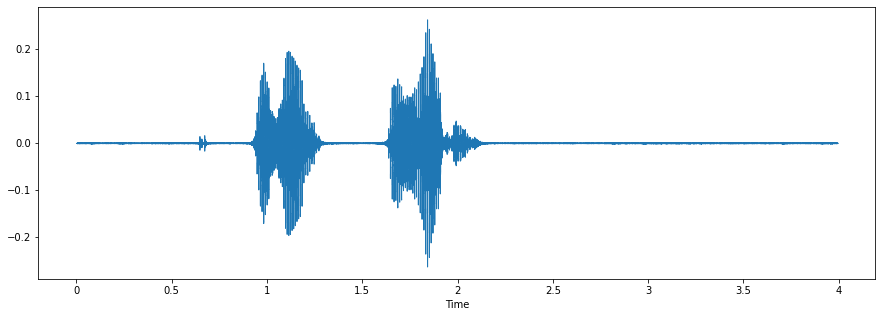

In [143]:
# % pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [144]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output12.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [145]:
livedf2= pd.DataFrame(data=livedf2)

In [146]:
livedf2 = livedf2.stack().to_frame().T

In [147]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-46.517818,-45.275799,-43.764629,-43.687759,-42.669556,-41.193832,-41.816002,-39.802532,-40.348526,-45.32143,...,-41.243366,-45.069416,-42.857552,-40.450382,-40.773495,-41.876789,-41.355694,-40.475853,-39.304695,-42.84827


In [148]:
twodim= np.expand_dims(livedf2, axis=2)

In [149]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 16ms/step


In [150]:
livepreds

array([[2.1086775e-21, 1.3466033e-30, 1.1818043e-23, 1.5985803e-17,
        3.8646202e-25, 1.0840431e-06, 2.1238557e-05, 1.1453562e-01,
        8.8543802e-01, 3.9657184e-06]], dtype=float32)

In [151]:
livepreds1=livepreds.argmax(axis=1)

In [152]:
liveabc = livepreds1.astype(int).flatten()

In [153]:
livepredictions = (lb.inverse_transform((liveabc)))

print("The predicted gender is '{}' and the emotion is '{}'.".format(*livepredictions[0].split("_")))

The predicted gender is 'male' and the emotion is 'happy'.
